In [1]:
%matplotlib inline

import pickle as pkl
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
from scipy.io import loadmat

In [3]:
trainset = loadmat('data/train_32x32.mat')
testset = loadmat('data/test_32x32.mat')


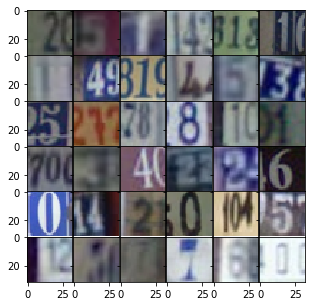

In [4]:
idx = np.random.randint(0, trainset['X'].shape[3], size=36)
fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(5, 5))
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(trainset['X'][:,:,:,ii], aspect='equal')
    ax.xaxis.set_visible(True)
    ax.yaxis.set_visible(True)
plt.subplots_adjust(wspace=0, hspace=0)

データのスケールを揃える

In [5]:
def scale(x, feature_ranges=(-1, 1)):
    x = ((x - x.min()) / (255 - x.min()))
    
    min, max = feature_ranges
    x = x * (max - min) + min
    return x

Datasetのクラスを定義する

In [6]:
class Dataset:
    def __init__(self, train, test, val_frac=0.5, shuffle=False, scale_func=None):
        split_index = int(len(test['y']) * (1 - val_frac))
        self.test_x, self.valid_x = test['X'][:,:,:,:split_index], test['X'][:,:,:,split_index:]
        self.test_y, self.valid_y = test['y'][:split_index], test['y'][split_index:]
        self.train_x, self.train_y = train['X'], train['y']
        
        self.train_x = np.rollaxis(self.train_x, 3)
        self.valid_x = np.rollaxis(self.valid_x, 3)
        self.test_x = np.rollaxis(self.test_x, 3)
        
        if scale_func is None:
            self.scaler = scale
        else:
            self.scaler = scale_func
        self.shuffle = shuffle
    
    def batches(self, batch_size):
        if self.shuffle:
            idx = np.arange(len(dataset.train_x))
            np.random.shuffle(idx)
            self.train_x = self.train_x[idx]
            self.train_y = self.train_y[idx]
            
        n_batches = len(self.train_y)//batch_size
        for ii in range(0, len(self.train_y), batch_size):
            x = self.train_x[ii:ii+batch_size]
            y = self.train_y[ii:ii+batch_size]
            
            yield self.scaler(x),y
            
        
            

変数（プレースホルダー）を初期化する関数

In [7]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    return inputs_real, inputs_z

ジェネレーター関数の作成
（ランダムなノイズからデータを生成する処理）

In [8]:
def generator(z, output_dim, reuse=False, alpha=0.2, training=True):
    with tf.variable_scope('generator', reuse=reuse):
        x1 = tf.layers.dense(z, 4 * 4 * 512)
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=training)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=training)
        x2 = tf.maximum(alpha * x2, x2)
        #8*8*256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=training)
        x3 = tf.maximum(alpha * x3,x3)
        #16×16×128
        
        logits = tf.layers.conv2d_transpose(x3, output_dim, 5, strides=2, padding='same')
        #32*32*3
        
        out = tf.tanh(logits)
        
        return out


ディスクリミネーターの定義

In [9]:
def discriminator(x, reuse=False, alpha=0.2):
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(x, 64, 5, strides=2, padding='same')
        x1 = tf.maximum(alpha * x1, x1)
        #16*16*64
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        #8*8*128
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3,training=True)
        x3 = tf.maximum(alpha * x3, x3)
        #4*4*256
        
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits
        
        

損失感数の定義

In [10]:
def model_loss(input_real, input_z, output_dim, alpha=0.2):
    g_model = generator(input_z, output_dim,alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss
    
    

最適化処理関数

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


モデルの定義

In [12]:
class GAN:
    
    def __init__(self, real_size, z_size, learning_rate, alpha=0.2, beta1=0.5):
        tf.reset_default_graph()
        
        self.input_real, self.input_z = model_inputs(real_size, z_size)
        
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z, real_size[2], alpha=alpha)
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)
    

生成した画像を表示する関数

In [13]:
def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, sharex=True, sharey=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        img = ((img - img.min()) * 255 / (img.max() - img.min())).astype(np.uint8)
        ax.set_adjustable('box-forced')
        im = ax.imshow(img, aspect='equal')
        
    plt.subplots_adjust(wspace=0, hspace=0)
    
    return fig, axes

トレーニング関数の定義

In [14]:
def train(net, dataset, epochs, batch_size, print_every = 10, show_every=100, figsize=(5,5)):
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_size))
    
    
    samples, losses = [], []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            for x, y in dataset.batches(batch_size):
                steps += 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))
                
                _ = sess.run(net.d_opt, feed_dict={net.input_real: x, net.input_z: batch_z})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: x})
                
                if steps % print_every == 0:
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: x})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})
                    
                    print("Epoch {}/{}: ".format(e+1, epochs),
                         "D Loss: {:.4f}  ".format(train_loss_d),
                         "G Loss: {:.4f}  ".format(train_loss_g))
                    
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % show_every == 0:
                    gen_samples = sess.run(generator(net.input_z, 3, reuse=True, training=False), feed_dict={net.input_z: sample_z})
                    samples.append(gen_samples)
                    _ = view_samples(-1, samples, 6, 12, figsize=figsize)
                    plt.show()
                    
    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
        
    return losses, samples


ハイパーパラメータの初期化

In [16]:
real_size = (32, 32, 3)
z_size = 100
learning_rate = 0.0002
batch_size = 128
epochs = 25
alpha = 0.2
beta1 = 0.5

net = GAN(real_size, z_size, learning_rate, alpha=alpha, beta1=beta1)

トレーニングの実行

Epoch 1/1:  D Loss: 1.4860   G Loss: 0.5713  
Epoch 1/1:  D Loss: 0.5440   G Loss: 1.2967  
Epoch 1/1:  D Loss: 0.3393   G Loss: 1.5566  
Epoch 1/1:  D Loss: 0.1499   G Loss: 2.7499  
Epoch 1/1:  D Loss: 0.1997   G Loss: 2.4600  
Epoch 1/1:  D Loss: 0.1477   G Loss: 2.7361  
Epoch 1/1:  D Loss: 0.0960   G Loss: 3.0794  
Epoch 1/1:  D Loss: 0.2182   G Loss: 2.2486  
Epoch 1/1:  D Loss: 0.2523   G Loss: 2.1770  
Epoch 1/1:  D Loss: 1.0933   G Loss: 1.8717  


D:\Anaconda3\envs\tf16gpu\lib\site-packages\matplotlib\axes\_base.py:1334: MatplotlibDeprecationWarning: 
box-forced
  "2.2", "box-forced", obj_type="keyword argument")


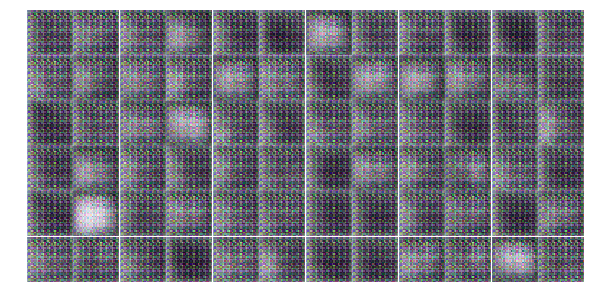

Epoch 1/1:  D Loss: 0.6149   G Loss: 1.8813  
Epoch 1/1:  D Loss: 0.4826   G Loss: 1.8486  
Epoch 1/1:  D Loss: 0.5619   G Loss: 1.3530  
Epoch 1/1:  D Loss: 0.2338   G Loss: 2.4215  
Epoch 1/1:  D Loss: 0.4446   G Loss: 2.7295  
Epoch 1/1:  D Loss: 0.6858   G Loss: 1.0647  
Epoch 1/1:  D Loss: 0.6502   G Loss: 1.6317  
Epoch 1/1:  D Loss: 0.9518   G Loss: 4.9571  
Epoch 1/1:  D Loss: 0.8564   G Loss: 1.2682  
Epoch 1/1:  D Loss: 0.5659   G Loss: 4.2297  


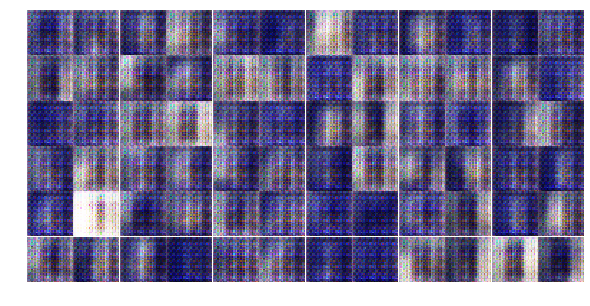

Epoch 1/1:  D Loss: 0.1162   G Loss: 2.8908  
Epoch 1/1:  D Loss: 0.2061   G Loss: 3.8308  
Epoch 1/1:  D Loss: 0.2610   G Loss: 4.7613  
Epoch 1/1:  D Loss: 0.2844   G Loss: 1.8972  
Epoch 1/1:  D Loss: 1.4185   G Loss: 3.9899  
Epoch 1/1:  D Loss: 0.8677   G Loss: 0.9518  
Epoch 1/1:  D Loss: 1.2441   G Loss: 2.9632  
Epoch 1/1:  D Loss: 0.2347   G Loss: 3.6194  
Epoch 1/1:  D Loss: 0.5300   G Loss: 3.3328  
Epoch 1/1:  D Loss: 0.1220   G Loss: 3.1504  


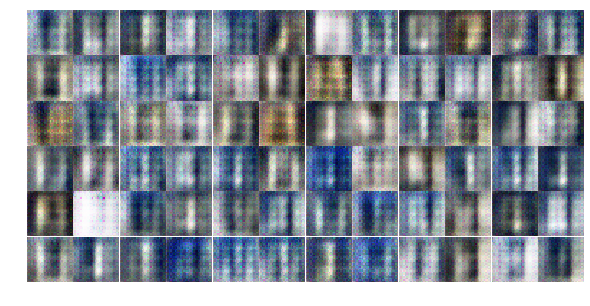

Epoch 1/1:  D Loss: 1.0524   G Loss: 1.7853  
Epoch 1/1:  D Loss: 0.8762   G Loss: 0.8592  
Epoch 1/1:  D Loss: 0.4117   G Loss: 2.3804  
Epoch 1/1:  D Loss: 0.4378   G Loss: 1.9619  
Epoch 1/1:  D Loss: 1.2610   G Loss: 1.7851  
Epoch 1/1:  D Loss: 0.5115   G Loss: 1.4475  
Epoch 1/1:  D Loss: 0.8238   G Loss: 1.2299  
Epoch 1/1:  D Loss: 0.7103   G Loss: 2.2667  
Epoch 1/1:  D Loss: 0.5349   G Loss: 1.5894  
Epoch 1/1:  D Loss: 0.7013   G Loss: 1.5142  


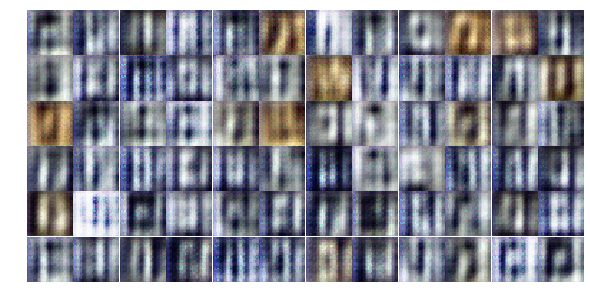

Epoch 1/1:  D Loss: 0.6269   G Loss: 1.4385  
Epoch 1/1:  D Loss: 0.6162   G Loss: 1.2757  
Epoch 1/1:  D Loss: 0.3343   G Loss: 2.0245  
Epoch 1/1:  D Loss: 0.2308   G Loss: 2.7119  
Epoch 1/1:  D Loss: 0.4876   G Loss: 1.6358  
Epoch 1/1:  D Loss: 0.5419   G Loss: 1.3234  
Epoch 1/1:  D Loss: 0.6292   G Loss: 1.5773  
Epoch 1/1:  D Loss: 0.5923   G Loss: 1.2692  
Epoch 1/1:  D Loss: 0.8289   G Loss: 0.8785  
Epoch 1/1:  D Loss: 0.6071   G Loss: 1.5421  


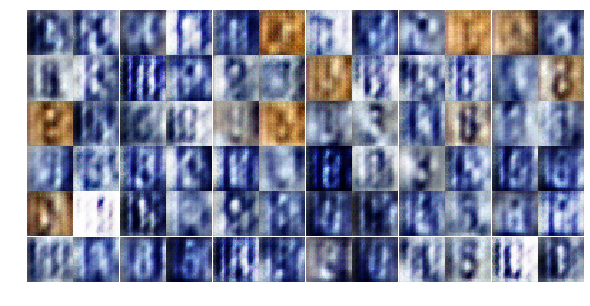

Epoch 1/1:  D Loss: 0.5489   G Loss: 1.7962  
Epoch 1/1:  D Loss: 0.7215   G Loss: 1.1075  
Epoch 1/1:  D Loss: 0.5261   G Loss: 1.4820  
Epoch 1/1:  D Loss: 1.0154   G Loss: 0.8522  
Epoch 1/1:  D Loss: 0.5155   G Loss: 2.1258  
Epoch 1/1:  D Loss: 0.3774   G Loss: 1.8544  
Epoch 1/1:  D Loss: 0.6102   G Loss: 1.9637  


In [17]:
dataset = Dataset(trainset, testset)

losses, samples = train(net, dataset, epochs, batch_size, figsize=(10, 5))